# Timeseries generation

Because I didn't really think through the previous data generation I will again now make a new class for the data generation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it

In [2]:
seedList1 = [  785, 38169, 44682, 15570, 13274, 44387, 28742, 34599, 39125, 18973]
seedList2 = [13367,  5901,  8258,  2184, 39489, 11901, 21542, 25640, 12128, 11222]

First we define a class "Timeseries" that can just solve any generic system of differential equations. As an example harmonic oscilattor is simulated below.

The reason why we define this ourself and not use one of the countless others models that already implement this, is because we can now controll the noise level per time step!. 

In [68]:
class Timeseries():
    def __init__(self, F, initialStates, timestep=0.01, tMax=100, integrationType = "Euler" 
                 ,noiseType = "LangevinLinear", noiseStrength = 0.01):
        self.typeTimeseries = "function"
        self.isGenerated = False
        
        # System setup
        self.F = F
        self.initialStates = initialStates
        self.numberOfExperiments, self.dimension = self.initialStates.shape if len(self.initialStates.shape)==2 else (1,len(self.initialStates))
        self.timestep = timestep
        self.tMax = tMax
        self.numberOfPoints = int(float(self.tMax)/float(self.timestep))
        
        # Save setup
        #self.time = np.arange(0,self.tMax,self.timestep)
        self.result = np.zeros(shape = (self.numberOfExperiments,self.numberOfPoints,self.dimension))
        self.result[:,0,:] = self.initialStates
        self.modelDiff = np.zeros(shape = (self.numberOfExperiments,self.numberOfPoints,self.dimension))
        self.noiseDiff = np.zeros(shape = (self.numberOfExperiments,self.numberOfPoints,self.dimension))
        #self.noiseContribution = self.result - self.modelContribution
        
        # Noise parameters
        self.seeds = seedList1[:self.numberOfExperiments]
        self.typeNoise = noiseType
        self.noiseParameters = {"strenght": noiseStrength}
        
        # Call method the method that sets the correct self.nextStepDiff method. 
        # When doing numerical integration nextStepDiff will be called. 
        self.setIntegration(integrationType) # Euler or Runge-Kutta
        
        # Parameters during Generation
        self.i = 0 # Current itteration
        self.e = 0 # Current experiment
        
        
    def setIntegration(self,integrationType):
        # Set here the "nextStep" function. It is allowed to point to a function outside the class!
        # One can then parameters to the outside function with lambda operator.
        if integrationType == "Euler":
            self.integrationType = integrationType
            self.nextStepDiff = self.eulerDiff # The euler integration is just method defined here. 
        elif integrationType == "insertOtherType":#like Runge-Kutta
            pass
        else:
            print(f"Integration type {integrationType} is not supported")
    
    def reset(self):
        self.result = np.zeros(shape = (self.numberOfExperiments,self.numberOfPoints,self.dimension))
        self.result[:,0,:] = self.initialState
        self.modelContribution = np.zeros(shape = (self.numberOfExperiments,self.dimension))
        self.noiseContribution = np.zeros(shape = (self.numberOfExperiments,self.dimension))
    
    def generate(self):
        for experiment in range(self.numberOfExperiments):
            # set seed for the experiment
            self.e = experiment
            np.random.seed(self.seeds[experiment])
            for i in range(self.numberOfPoints-1):# -1 because we look at the next state
                self.i = i+1
                currentState = self.result[experiment,i,:]
                # Compute next step and store it immediatly
                self.modelDiff[experiment,i+1] = self.nextStepDiff(currentState)
                self.noiseDiff[experiment,i+1] = self.sampleNoise(currentState)
                self.result[experiment,i+1] = self.result[experiment,i] + self.modelDiff[experiment,i+1] + self.noiseDiff[experiment,i+1]
                
    def sampleNoise(self, currentState):
        if self.typeNoise == "LangevinLinear":
            return  self.noiseParameters["strenght"] * currentState * np.sqrt(self.timestep) * np.random.normal(0, 1, self.dimension)
        
    def eulerDiff(self,currentState):
        return self.timestep*self.F(currentState)
    
    def plot(self,experiment=None):
        time = np.arange(0,self.tMax,self.timestep)
        
        for exp  in range(self.numberOfExperiments):
            if experiment is not None: # Go to the correct experiment number
                if exp!=experiment:
                    continue
                
            for j in range(self.dimension):
                plt.plot(time,self.result[exp,:,j],label=f"Dim.{j} exp.{exp}")
            
        plt.title("Timeseries")
        plt.xlabel("Time")
        plt.ylabel("Result") 

In [8]:
def harmonicOscillator(currentState,period):
    # currentState y = [x,v]
    # => dy/dt = F = [v,-period^2*x]
    return np.array([currentState[1], -1 * period**2 * currentState[0]])

period = 0.5
initialState = np.array([1,0])

Fharmonic = lambda state: harmonicOscillator(state,period)

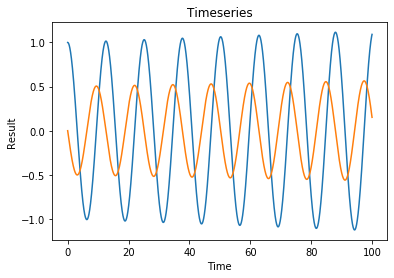

In [9]:
harmonicTS = Timeseries(F=Fharmonic, initialStates=initialState, timestep= 0.01, noiseStrength=0.0)
harmonicTS.generate()
harmonicTS.plot()

Now we upgrade it to specifically a timeseries that generates GLV.

In [97]:
class TS_GLV(Timeseries):
    def __init__(self, numberSpecies, numberExperiments, noiseParameters, genParameters, pertuParameters):
        self.numberSpecies = numberSpecies
        self.numberExperiments = numberExperiments
        self.genParameters = genParameters
        self.noiseParameters = noiseParameters
        self.pertuParameters = pertuParameters
        
        # Steady State. For now this is just scaled. As is discussed before. 
        self.isScaled = True
        self.steadystate = np.ones(self.numberSpecies)
        
        # Set parameters just equal to zero for now.
        self.growth = np.zeros((self.numberExperiments,self.numberSpecies))
        self.interactionMatrix = np.zeros((self.numberExperiments,self.numberSpecies,self.numberSpecies))
        self.parametersAreGen = False
        
        # Set seed for random
        self.seedGen = seedList2[:self.numberExperiments]
        
        # Generate random matrix
        self.generateParameter()
        # Generate random initial
        self.initialStates = self.pertubation(True) # Seed for initial will follow up on the seed of generateParameter
        
        
        Timeseries.__init__(self,self.GLV, self.initialStates, 
                            noiseType=self.noiseParameters["noiseType"], noiseStrength=self.noiseParameters["noiseStrength"])
        
    
    def generateParameter(self):
        for experiment in range(self.numberExperiments):
            np.random.seed(self.seedGen[experiment])
            
            IsStable = False
            while not IsStable:
                if self.isScaled:# Parameters size is steady state depended! 
                    newMatrix = self.genParameters["interactionStrenght"]*np.random.randn(self.numberSpecies,self.numberSpecies)
                    selfInter = np.random.uniform(-1.9,-0.1,size=self.numberSpecies)
                    np.fill_diagonal(newMatrix, selfInter)
                    newGrowth = - newMatrix.dot(self.steadystate)
                
                    IsStable = self.isStable(newMatrix, self.steadystate)
                else:
                    print("Error: Non scaled is not supported yet!")
                    return
            self.growth[experiment] = newGrowth
            self.interactionMatrix[experiment] = newMatrix
        self.parametersAreGen = True
        
    def generate(self): # redefine generate to now also add pertubation;
        for experiment in range(self.numberOfExperiments):
            # set seed for the experiment
            self.e = experiment
            np.random.seed(self.seeds[experiment])
            for i in range(self.numberOfPoints-1):# -1 because we look at the next state
                self.i = i+1
                currentState = self.result[experiment,i,:]
                # Compute next step and store it immediatly
                self.modelDiff[experiment,i+1] = self.nextStepDiff(currentState)
                self.noiseDiff[experiment,i+1] = self.sampleNoise(currentState)
                pertubation = self.pertubation(); # For the moment this is not saved.
                self.result[experiment,i+1] = self.result[experiment,i] + self.modelDiff[experiment,i+1] + self.noiseDiff[experiment,i+1] + pertubation
                     
    def isStable(self,matrix, steady):
        J = np.diag(steady).dot(matrix) # Jacobian
        if np.any(np.real(np.linalg.eigvals(J)) > 0):
            return False
        else:
            return True
            
    def pertubation(self,isInitial=False):
        if isInitial:
            return self.steadystate + self.pertuParameters["strenght"]*np.random.randn(self.numberExperiments,self.numberSpecies)
        else:
            number = int(self.pertuParameters["period"]/self.timestep)
            if self.i%number==0:
                return self.pertuParameters["strenght"]*np.random.randn(self.numberSpecies)
            else:
                return np.zeros(self.numberSpecies)
            
    def GLV(self, currentState):
        if self.parametersAreGen == False:
            print("Error: model parameters have not been generated")
            return
        return currentState * self.growth[self.e] + currentState * np.dot(self.interactionMatrix[self.e],currentState)
        
        

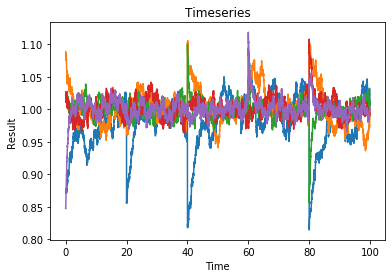

In [104]:
noiseSetting = {
    "noiseType" : "LangevinLinear",
    "noiseStrength" : 0.02
}

pertuSetting = {
    "period" : 20,
    "strenght" : 0.1
}

genSetting = {
    "interactionStrenght" : 0.02
}

TS = TS_GLV(5,5,noiseSetting,genSetting,pertuSetting)
TS.generate()
TS.plot(0)